# SNP filtering

I have finished calling variants genome-wide for all 120 samples using `freebayes` <br>

I split the variant VCF into INDELs, SNPs, MNPs, invariant, and other using `bcftools` <br>
I'll only look at SNPs in this notebooks since that's what we're interested in. <br>

I have converted the SNP vcf to a Zarr database using `vcf_to_zarr` from `scikit-allel` <br>
This is what I'll load and work with in this notebook

## Setup

### Import packages

In [1]:
import allel
import zarr

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import numpy as np

### Import SNP Zarr database

Example Zarr database structure for chromosome 1 with 9,081,218 sites. Zarr databases are nested, and contain the following subdirectories:

 - `calldata`: Genotype annotations (i.e., FORMAT field in VCF)
 - `samples`: Sample IDs
 - `variants`: Site-specific annotations (e.g., INFO field in VCF)
 
Data are stored as `numpy` arrays for easy slicing, indexing, plotting, etc.

### Import chromosomes as list

`chrom_file` is a text file with the white clover chromosome names, listed one per line

This file can be created by (for example) running the following command on a sample VCF (with at least one site on each chromosome) <br>

`zgrep -v '^#' sample.vcf.gz | cut -f 1 | uniq > organism.chromosomes`

**Note:** In white clover, chromosomes ending in odd numbers originate from _Trifolium occidentale_ whereas chromosomes ending with even numbers originate from _Trifolium pallescens_

### Import SNPs and Invariant sites

**Note: Only looking at chromosome 1**

In [2]:
snp_zarr_path = '../../results/variants/zarr_db/CM019101.1/CM019101.1_allSamples_snps_sorted.zarr/'
snp_callset = zarr.open_group(snp_zarr_path, mode='r')
invar_zarr_path = '../../results/variants/zarr_db/CM019101.1/CM019101.1_allSamples_invariant_sorted.zarr/'
invar_callset = zarr.open_group(invar_zarr_path, mode='r')

## Functions

In [3]:
def extract_zarr_annotation(subdir, annot, zarr_db = snp_callset):
    """Extract site and genotype annotations from Zarr database by chromosome
    
    Args:
        chrom (str): Chromosome name as string
        subdir (str): Subdirectory for annotation. 'variants' for site-specific annotations
            (e.g., INFO field) or 'calldata' for genotype annotations (i.e., FORMAT field)
        annot (str): Annotation to extract (e.g., 'QUAL', 'ALT', 'DP')
        zarr_db (:obj: `zarr.hierarchy.Group`): Zarr database produced using `vcf_to_zarr`
            from `scikit-allel`
        
    Returns:
        zarr_array (:obj:`zarr.core.Array`): VCF annotation extracted as `numpy`
            array.
    """
    
    if subdir == 'samples':
        zarr_array = zarr_db['{0}'.format(subdir)]
    else:
        zarr_array = zarr_db['{0}/{1}'.format(subdir, annot)]
    
    return zarr_array


def subset_array(array, indices):
    """Little helper function to subset sites or samples by array of indices
    
    Args:
        array (:obj:`numpy.ndarray`): Array to be subset
        indices (:obj:`numpy.ndarray` of :obj:`int`): Array of integers representing
            the indices of variants passing QUAL filter.
    
    Returns:
        array_out (:obj:`numpy.ndarray`): Numpy array subsetting at indices
    """
    
    array_out = np.take(array, indices, axis=0)

    
    return array_out
    
    
def filter_qual(zarr_qual_array, qual_thresh):
    """Find indices of variants passing QUAL filter
    
    Args:
        zarr_qual_array (:obj:`zarr.core.Array`): Zarr array with variant QUAL annotations
        qual_thresh (int): Threshold for QUAL. Variants greater that `qual_thresh` will be kept.
        
    Returns:
        indices_to_keep (:obj:`numpy.ndarray` of :obj:`int`): Array of integers representing
            the indices of variants passing QUAL filter.
    """    
    qual_array = zarr_qual_array[:]  # Extract QUAL values as numpy array

    total_sites = len(qual_array)  # Total number of variants
    indices_to_keep = np.where(qual_array >= qual_thresh)[0]
    
    sites_passingQUAL = len(indices_to_keep)  # Number of sites passing QUAL filter
    
    prop_passingQUAL = round((sites_passingQUAL / total_sites) * 100, 2)
    print("{0}% ({1}) of sites have quality scores greater or equal to {2}".format(prop_passingQUAL, sites_passingQUAL, qual_thresh))
    
    return indices_to_keep


def lowDP_GTrecode(zarr_dp_array, zarr_gt_array, minDP = 3, subset = None):
    """Recode genotypes with Depth < minDP as missing
    
    Args:
        zarr_dp_array (:obj:`zarr.core.Array`): Zarr array with variant FORMAT/DP annotations
        zarr_gt_array (:obj:`zarr.core.Array`): Zarr array with variant FORMAT/GT annotations
        minDP (int): Minimum depth threshold. Genotypes less than `minDP` will be recoded as missing
        subset (:obj:`numpy.ndarray` of :obj:`int`): Numpy array of indices for subsetting.
        
    Returns:
        GT_array_rep (:obj:`numpy.ndarray` of :obj:`list` of :obj:`int`): Numpy array with one list per 
            site and sample representing the two diploid alleles. Alleles can be 0 (REF), 1 (ALT), or -1 (Missing)
    """ 
    
    GT_vals_rep = []
    DP_array = zarr_dp_array[:]  # Extract all DP values as numpy array
    GT_array = zarr_gt_array[:]  # Extract all GT values as numpy array
    
    if subset is not None:
        DP_array = subset_array(DP_array, indices = subset)
        GT_array = subset_array(GT_array, indices = subset)

    GT_array_rep = GT_array  # Duplicate genotype array
    GT_array_rep[DP_array < minDP] = [-1, -1]  # Where DP < `minDP`, recode genotype as missing (i.e., [-1, -1])
    
    return GT_array_rep


def prop_missing_sites(gt_array):
    """Return proportion of sites with missing genotype calls
    
    Args:
        gt_array (:obj:`numpy.ndarray` of :obj:`list` of :obj:`int`): Numpy array with one list per 
            site and sample representing the two diploid alleles. Alleles can be 0 (REF), 1 (ALT), or -1 (Missing)
            
    Returns:
        prop_miss_array (:obj:`numpy.ndarray` of :obj:`float`): Numpy array with proportion of sites
            with missing genotype calls per sample. 
    """
    
    GT_array = allel.GenotypeArray(gt_array)
    num_sites = GT_array.n_variants
    num_samples = GT_array.n_samples

    prop_miss_array = GT_array.is_missing().sum(axis = 0) / num_sites
    
    return prop_miss_array


def filter_missGT(gt_array, missing_gt_prop = 0.2):
    """Find indices of variants passing missing genotype filter
    
    Args:
        gt_array (:obj:`numpy.ndarray` of :obj:`list` of :obj:`int`): Numpy array with one list per 
            site and sample representing the two diploid alleles. Alleles can be 0 (REF), 1 (ALT), or -1 (Missing)
        missing_gt_prop (int): Threshold for missing genotypes. Variants with fewer than this proportion of
            missing genotype calls will be kept. 
        
    Returns:
        indices_to_keep (:obj:`numpy.ndarray` of :obj:`int`): Array of integers representing
            the indices of variants passing missing GT filter.
    """   
    total_sites = len(gt_array)  # Total number of variants
    
    gtArray = allel.GenotypeArray(gt_array)
    num_samples = gtArray.n_samples
    
    missing_gt_boolArray = gtArray.is_missing()
    prop_missing_gt = missing_gt_boolArray.sum(axis = 1) / num_samples
    
    missGT_indicesToKeep = np.where(prop_missing_gt <= missing_gt_prop)[0]

    sites_passingGT = len(missGT_indicesToKeep)

    prop_passingGT = round((sites_passingGT / total_sites) * 100, 2)
    prop_toKeep = 1 - missing_gt_prop
    num_sample_threshold_toKeep = round(num_samples * prop_toKeep)
    print("{0}% ({1}) of sites have at least {2}% ({3}) of samples with genotype calls".format(prop_passingGT, sites_passingGT, prop_toKeep * 100, num_sample_threshold_toKeep))
    
    return missGT_indicesToKeep, prop_missing_gt

def plot_windowed_variant_density(pos, window_size, title=None):
    # http://alimanfoo.github.io/2016/06/10/scikit-allel-tour.html
    # setup windows 
    bins = np.arange(0, pos.max(), window_size)
    
    # use window midpoints as x coordinate
    x = (bins[1:] + bins[:-1])/2
    
    # compute variant density in each window
    h, _ = np.histogram(pos, bins=bins)
    y = h / window_size
    
    # plot
    fig, ax = plt.subplots(figsize=(12, 3))
    sns.despine(ax=ax, offset=10)
    ax.plot(x, y)
    ax.set_xlabel('Chromosome position (bp)')
    ax.set_ylabel('Variant density (bp$^{-1}$)')
    if title:
        ax.set_title(title)

## Filtering 

For filtering, I will loosly follow the suggestions made in [this tutorial](http://www.ddocent.com/filtering/) by
Jon Puritz, with some modifications. <br>
These suggested filtering criteria are similiar to those used
by [Julia Kreiner](https://github.com/jkreinz/Amaranthus-population-genomics/blob/master/snp_calling_filtering/filtering_vcfs.sh) in her recent paper.

For computational efficiency, I'm only filtering chromosome 1

### Order-dependent filtering

Criteria 2, 3, and 4 below are order-dependent. Following filtering by criteria 1 to 4 below, we should <br>
end up with a set of sites that have a high probability of being polymorphic (criteria 1: QUAL) and have <br>
have a high proportion of samples with genotype calls (criteria 4) sequenced to reasonable depth for a joint caller <br>
(criteria 2).

We'll also only keep individuals that sequenced well (i.e., have little missing data: criteria 3). 

#### Criteria 1: QUAL

The `QUAL` field is the phred-scaled probability that the site is polymorphic. <br>

`QUAL` of 30 represents a 99.9% change the site is variant.  <br>

_Filter: QUAL > 30_

In [4]:
# Get QUAL scores for all sites across all chromosomes
# Chromososmes stored as separate arrays
qual_vals = extract_zarr_annotation(subdir = 'variants', annot = 'QUAL')

In [5]:
# Find indices of variants passing QUAL filter
qual_indicesToKeep = filter_qual(zarr_qual_array = qual_vals, qual_thresh = 30)
qual_indicesToKeep

45.31% (4163393) of sites have quality scores greater or equal to 30


array([      5,      15,      17, ..., 9188445, 9188447, 9188448])

#### Criteria 2: Depth per sample

Re-code sample genotpye calls where DP < `minDP` as missing. <br>

For our purpose, we want high quality genotype calls and sites with little missing data, <br>
so it's useful to treat samples with low depth at a site as having missing genotype calls. <br>

We'll also eventually filter on missing genotypes directly. <br>

Arrays can be indexed as `array[sites, samples]`

In [6]:
DP_vals = extract_zarr_annotation(subdir = 'calldata', annot = 'DP')
GT_vals = extract_zarr_annotation(subdir = 'calldata', annot = 'GT')

In [7]:
# Get genotype array with GTs with DP < minDP recoded as missing
GT_array_rep = lowDP_GTrecode(zarr_dp_array = DP_vals, zarr_gt_array = GT_vals, minDP = 3, subset = qual_indicesToKeep)

In [8]:
subset_array(DP_vals[:], qual_indicesToKeep)[3000006:3000010, 0:4]

array([[4, 1, 8, 3],
       [4, 2, 8, 3],
       [1, 2, 7, 3],
       [1, 2, 7, 3]], dtype=int16)

In [9]:
allel.GenotypeArray(subset_array(GT_vals[:], qual_indicesToKeep)[3000006:3000010, 0:4])

,0,1,2,3
0,1/1,0/0,1/1,1/1
1,1/1,1/1,1/1,0/1
2,1/1,1/1,1/1,0/1
3,0/0,0/0,0/0,0/0


In [10]:
# Notice Genotypes above with DP < 3 are now coded as missing (./.)
allel.GenotypeArray(GT_array_rep[3000006:3000010, 0:4])

,0,1,2,3
0,1/1,./.,1/1,1/1
1,1/1,./.,1/1,0/1
2,./.,./.,1/1,0/1
3,./.,./.,0/0,0/0


#### Criteria 3: Missing sites by individual

Estimate the proportion of sites with missing data for each sample <br>

Remove individuals with high proportion of missing data (i.e. those that didn't sequence well) <br>
The threshold for removal should be based on an empirical distribution of the proportion of missing sites. 

_Filter: Prop missing sites < 50%_

**Plot proportion of missing data by per sample**

In [11]:
prop_miss_array = prop_missing_sites(gt_array = GT_array_rep)
prop_miss_array

array([0.18066635, 0.13994956, 0.20149815, 0.21956587, 0.16991286,
       0.15890981, 0.19251413, 0.1566787 , 0.249613  , 0.13584617,
       0.16902224, 0.20235443, 0.17587938, 0.18680341, 0.19286625,
       0.12938918, 0.17534424, 0.22099715, 0.16737334, 0.48357698,
       0.21839663, 0.45173612, 0.17795293, 0.2109049 , 0.17870448,
       0.1187798 , 0.25423591, 0.30599754, 0.23203719, 0.21082612,
       0.11512797, 0.16447739, 0.21052781, 0.29170607, 0.4589951 ,
       0.20887483, 0.33111959, 0.19957352, 0.18547588, 0.160729  ,
       0.25734347, 0.16468779, 0.21757639, 0.16886587, 0.24612594,
       0.36982168, 0.34363583, 0.1624132 , 0.19862862, 0.15315585,
       0.19101079, 0.20151064, 0.26045367, 0.27616129, 0.31438685,
       0.30714516, 0.3618234 , 0.19230997, 0.31926604, 0.16962559,
       0.30499403, 0.22690459, 0.17897037, 0.14026877, 0.24366352,
       0.38783944, 0.23818121, 0.14213431, 0.81714217, 0.81173745,
       0.20705924, 0.22788769, 0.60692637, 0.23096282, 0.26232

**Raw data plot**

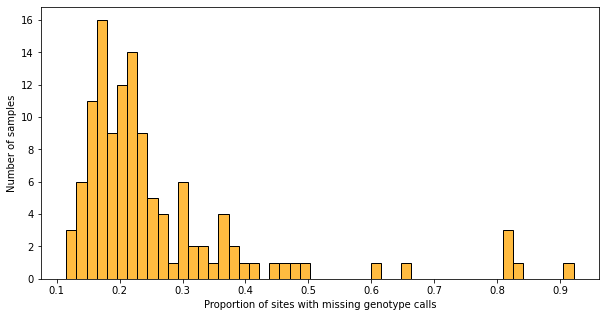

In [14]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 5))
sns.histplot(prop_miss_array, bins=50, color = "orange", ax = ax)
ax.set(xlabel='Proportion of sites with missing genotype calls', ylabel='Number of samples')
plt.show()

**Cumulative density plot**

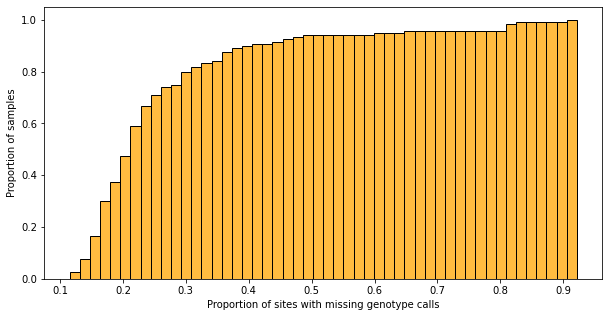

In [15]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 5))
sns.histplot(prop_miss_array, cumulative=True, stat='density', bins=50, color = "orange", ax = ax)
ax.set(xlabel='Proportion of sites with missing genotype calls', ylabel='Proportion of samples')
plt.show()

In [16]:
prop_thresh = 0.5
bad_sample_array = (prop_miss_array > prop_thresh)
num_samples_above_thresh = bad_sample_array.sum()
print("If we set the missing site threshold to {0}, we will toss {1} samples".format(prop_thresh, num_samples_above_thresh))

If we set the missing site threshold to 0.5, we will toss 7 samples


**Identify samples that didn't sequence well**

In [17]:
sample_array = extract_zarr_annotation(subdir = 'samples', annot = None)

In [18]:
sample_array[:][bad_sample_array]

array(['$s_97_4', '$s_23_17', '$s_80_18', '$s_7_14', '$s_37_12',
       '$s_23_12', '$s_54_9'], dtype=object)

In [19]:
# Remove those samples from Genotype Array
good_sample_array = np.invert(bad_sample_array)
gt_array_goodSamples = GT_array_rep[:,good_sample_array]

### Order-independent filtering

The remaining criteria are order-independent; they filter on site-level annotations and filter on things like <br>
allele balance, strand-bias

**Generate variant table with annotations of interest**

In [21]:
# Get array of SNP positions alongs chromosome 1
pos_vals = extract_zarr_annotation(subdir = 'variants', annot = 'POS')
pos_vals[:].shape

(9188461,)

In [22]:
# Keep only positions that passed QUAL filter
positions_passQUAL = np.take(pos_vals[:], qual_indicesToKeep, axis = 0)
positions_passQUAL.shape

(4163393,)

In [23]:
# Created sorted indext for later subsetting of Variant table
positions_index = allel.SortedIndex(positions_passQUAL)
positions_index

0,1,2,3,4,...,4163388,4163389,4163390,4163391,4163392
2118,5343,5498,7744,7952,...,95901844,95901867,95901878,95901892,95901903


In [25]:
# Chunked table of all variants
variants = allel.VariantChunkedTable(snp_callset['variants'], 
                                     names=['POS', 'REF', 'ALT', 'QUAL', 'DP', 'AB', 'SAF', 'SAR', 'SRF', 'SRR', 'MQM', 'MQMR', 'PAIRED', 'PAIREDR'],
                                     index='POS')

In [26]:
# Variants passing QUAL and missing genotype filters (i.e., criteria 1 to 4 above)
variants_preFiltered = variants[:][np.isin(variants['POS'], positions_index)]

#### Criteria 4: Allele balance

Allele balance measures the ratio of reads showing the reference allele to all reads. We don't <br>
want sites where there is a skew in the number of reads supporting the REF or the ALT allele

_Filter: AB > 0.25 & AB < 0.75 | AB < 0.01_

**Raw data plot**

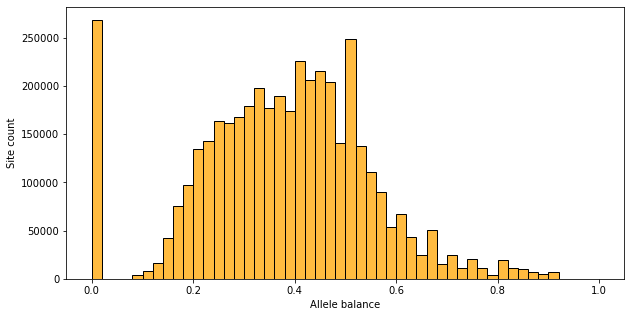

In [27]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 5))
sns.histplot(variants_preFiltered['AB'], bins = 50, color = "orange", axes = ax)
ax.set(xlabel='Allele balance', ylabel='Site count')
plt.show()

**Cumulative density plot**

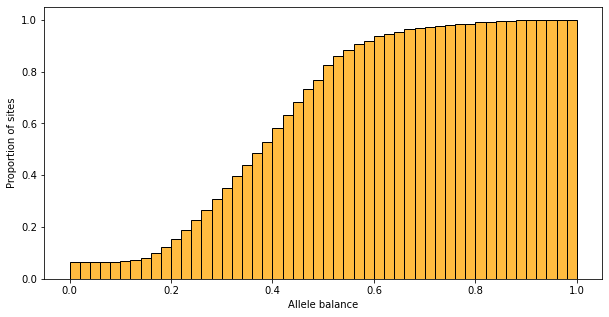

In [28]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 5))
sns.histplot(variants_preFiltered['AB'], cumulative=True, stat='density', bins = 50, color = "orange", axes = ax)
ax.set(xlabel='Allele balance', ylabel='Proportion of sites')
plt.show()

In [29]:
AB_expr = '((AB > 0.25) & (AB < 0.75)) | (AB < 0.01)'
AB_filt = variants_preFiltered.eval(AB_expr)
AB_pass = variants_preFiltered.compress(AB_filt)

In [30]:
num_sites_keptAB = np.count_nonzero(AB_filt)
num_sites_filteredAB = np.count_nonzero(~AB_filt)
print("Removed a total of {0} sites failing AB filter. {1} sites remaining".format(num_sites_filteredAB, num_sites_keptAB))

Removed a total of 711098 sites failing AB filter. 3452295 sites remaining


#### Criteria 5: Strand bias

We want to avoid sites where alleles are only seen on one strand. <br>

Jon Puritz suggests the following filter:

Keep sites that have over 100 times more forward alternate reads than reverse alternate reads and 100 <br>
times more forward reference reads than reverse reference reads along with the reciprocal

_Filter: SAF / SAR > 100 & SRF / SRR > 100 | SAR / SAF > 100 & SRR / SRF > 100_

However, this filter results in the loss of the vast majority of sites (only 737 remain post-filter). <br>
Julia Kreiner saw the same thing in her data. An alternative approach is to keep sites where both the <br>
forward and reverse strand show the ALT allele, as suggested by [Erik Garrison](https://wiki.uiowa.edu/download/attachments/145192256/erik%20garrison%20-%20iowa%20talk%202.pdf?api=v2), the author of `freebayes`. 

_Suggested filter: SAF > 0 & SAR > 0_

**SAF:** Number of reads with ALT allele of forward strand <br>
**SAR:** Number of reads with ALT allele of reverse strand

In [31]:
SB_expr = '(SAF > 0) & (SAR > 0)'
SB_filt = AB_pass.eval(SB_expr)
SB_pass = AB_pass.compress(SB_filt)

In [32]:
num_sites_keptSB = np.count_nonzero(SB_filt)
num_sites_filteredSB = np.count_nonzero(~SB_filt)
print("Removed a total of {0} sites failing Strand Bias filter. {1} sites remaining".format(num_sites_filteredSB, num_sites_keptSB))

Removed a total of 39074 sites failing Strand Bias filter. 3413221 sites remaining


**Raw data plot**

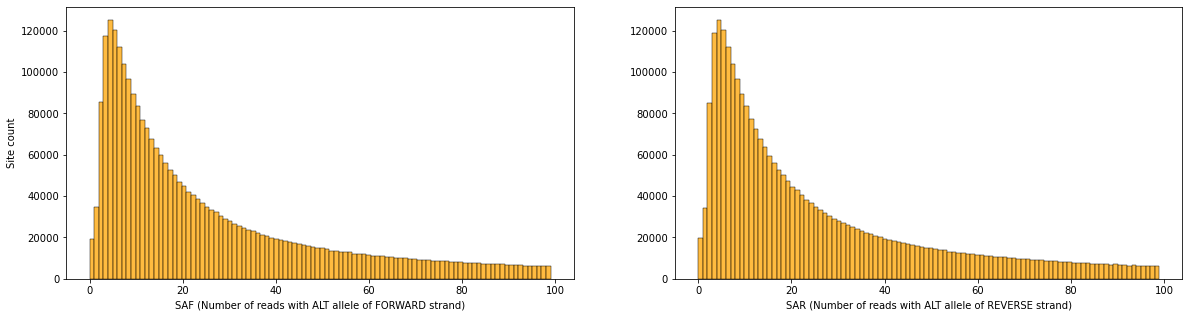

In [33]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20, 5))

sns.histplot(AB_pass['SAF'][AB_pass['SAF'] < 100], bins = 100, color = "orange", ax = ax[0])
ax[0].set(xlabel='SAF (Number of reads with ALT allele of FORWARD strand)', ylabel='Site count')
# plt.show()

sns.histplot(AB_pass['SAR'][AB_pass['SAR'] < 100], bins = 100, color = "orange", ax = ax[1])
ax[1].set(xlabel='SAR (Number of reads with ALT allele of REVERSE strand)', ylabel='')

plt.show()

**Cumulative density plot**

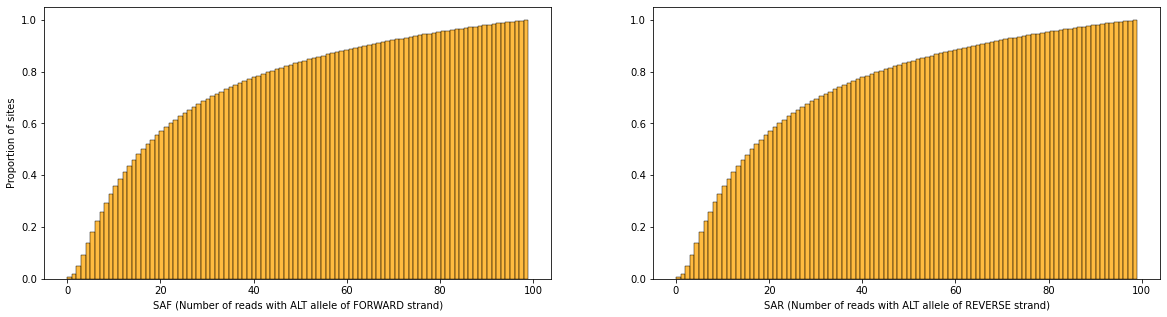

In [34]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20, 5))

sns.histplot(AB_pass['SAF'][AB_pass['SAF'] < 100], cumulative=True, stat='density', bins = 100, color = "orange", ax = ax[0])
ax[0].set(xlabel='SAF (Number of reads with ALT allele of FORWARD strand)', ylabel='Proportion of sites')
# plt.show()

sns.histplot(AB_pass['SAR'][AB_pass['SAR'] < 100], cumulative=True, stat='density', bins = 100, color = "orange", ax = ax[1])
ax[1].set(xlabel='SAR (Number of reads with ALT allele of REVERSE strand)', ylabel='')

plt.show()

#### Criteria 6: Mapping quality

We don't want sites where the mapping quality of reads supporting the ALT and REF allele <br>
are very different.

_Original filter: MQM / MQMR > 0.9 & MQM / MQMR < 1.05_

The filter above is the one suggested by Jon Puritz. However, it's not clear to me <br>
why the mapping quality ratios are asymmetrical.

_Suggested filter: MQM / MQMR > 0.9 & MQM / MQMR < 1.10_

_Updated filter:_ MQM >= 30 & MQMR >= 30  (Updated following meeting with Marc and Rob)

**MQM:** Mean Mapping Quality of reads supporting the ALT allele <br>
**MQMR:** Mean Mapping Quality of reads supporting the REF allele

In [35]:
MQ_expr = '(MQM >= 30) & (MQMR >= 30)'
MQ_filt = SB_pass.eval(MQ_expr)
MQ_pass = SB_pass.compress(MQ_filt)

In [36]:
num_sites_keptMQ = np.count_nonzero(MQ_filt)
num_sites_filteredMQ = np.count_nonzero(~MQ_filt)
print("Removed a total of {0} sites failing Mapping Quality filter. {1} sites remaining".format(num_sites_filteredMQ, num_sites_keptMQ))

Removed a total of 480019 sites failing Mapping Quality filter. 2933202 sites remaining


**Raw data plot**

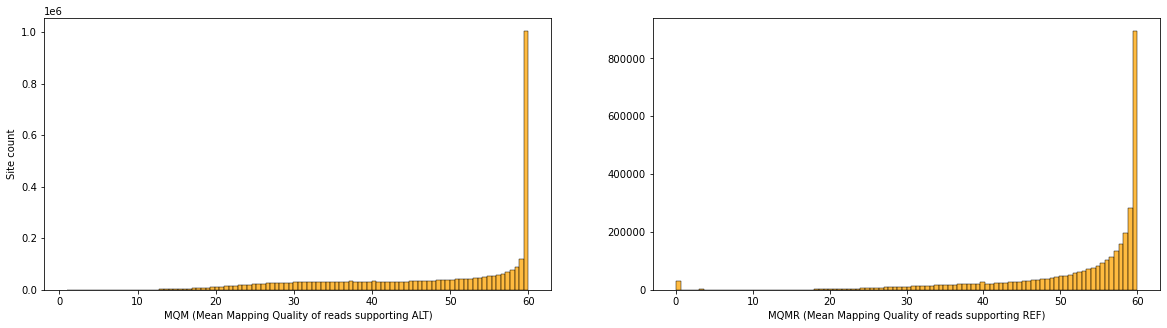

In [37]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20, 5))

sns.histplot(AB_pass['MQM'], bins = 100, color = "orange", ax = ax[0])
ax[0].set(xlabel='MQM (Mean Mapping Quality of reads supporting ALT)', ylabel='Site count')
# plt.show()

sns.histplot(AB_pass['MQMR'], bins = 100, color = "orange", ax = ax[1])
ax[1].set(xlabel='MQMR (Mean Mapping Quality of reads supporting REF)', ylabel='')

plt.show()

**Cumulative density plots**

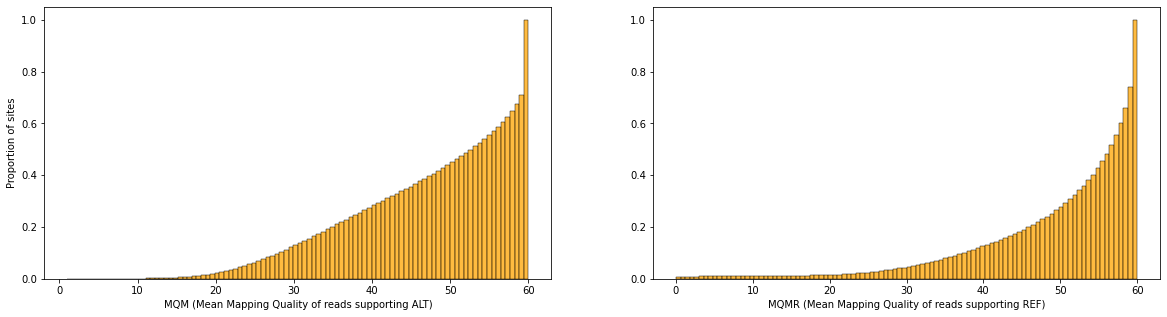

In [38]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20, 5))

sns.histplot(AB_pass['MQM'], bins = 100, cumulative=True, stat='density', color = "orange", ax = ax[0])
ax[0].set(xlabel='MQM (Mean Mapping Quality of reads supporting ALT)', ylabel='Proportion of sites')
# plt.show()

sns.histplot(AB_pass['MQMR'], bins = 100, cumulative=True, stat='density', color = "orange", ax = ax[1])
ax[1].set(xlabel='MQMR (Mean Mapping Quality of reads supporting REF)', ylabel='')

plt.show()

#### Criteria 7: Paired vs unpaired

Don't want sites where there is a bias in the paired status of reads supporting the ALT <br>
and REF alleles.

_Filter: PAIRED > 0.05 & PAIREDR > 0.05 & PAIREDR / PAIRED < 1.75 & PAIREDR / PAIRED > 0.25 | PAIRED < 0.05 & PAIREDR < 0.05_

**PAIRED:** Proportion of ALT alleles supported by paired reads <br>
**PAIREDR:** Proportion of REF alleles supported by paired reads

**Raw data plot**

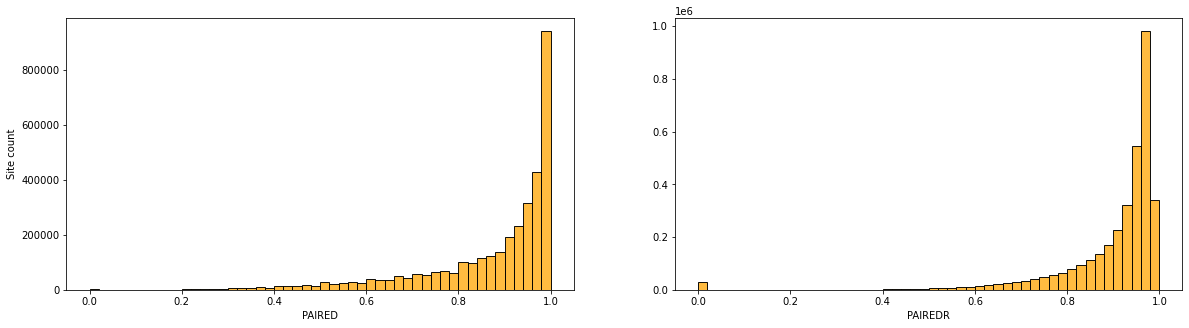

In [39]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20, 5))

sns.histplot(AB_pass['PAIRED'], bins = 50, color = "orange", ax = ax[0])
ax[0].set(xlabel='PAIRED', ylabel='Site count')
# plt.show()

sns.histplot(AB_pass['PAIREDR'], bins = 50, color = "orange", ax = ax[1])
ax[1].set(xlabel='PAIREDR', ylabel='')

plt.show()

**Cumulative density plots**

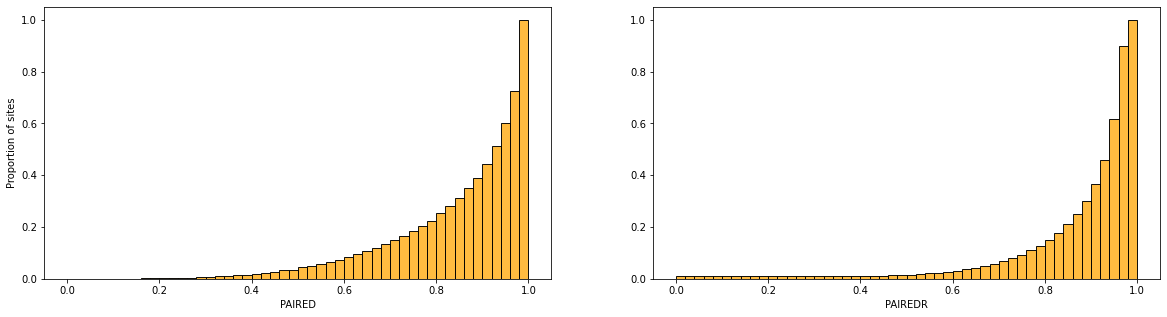

In [40]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20, 5))

sns.histplot(AB_pass['PAIRED'], cumulative=True, stat='density', bins = 50, color = "orange", ax = ax[0])
ax[0].set(xlabel='PAIRED', ylabel='Proportion of sites')
# plt.show()

sns.histplot(AB_pass['PAIREDR'], cumulative=True, stat='density', bins = 50, color = "orange", ax = ax[1])
ax[1].set(xlabel='PAIREDR', ylabel='')

plt.show()

In [41]:
PR_expr = '((PAIRED > 0.05) & (PAIREDR > 0.05) & (PAIREDR / PAIRED < 1.75 )& (PAIREDR / PAIRED > 0.25)) | ((PAIRED < 0.05) & (PAIREDR < 0.05))'
PR_filt = MQ_pass.eval(PR_expr)
PR_pass = MQ_pass.compress(PR_filt)

<string>:1: RuntimeWarning: divide by zero encountered in true_divide


In [42]:
num_sites_keptPR = np.count_nonzero(PR_filt)
num_sites_filteredPR = np.count_nonzero(~PR_filt)
print("Removed a total of {0} sites failing Pairedness filter. {1} sites remaining".format(num_sites_filteredPR, num_sites_keptPR))

Removed a total of 67028 sites failing Pairedness filter. 2866174 sites remaining


#### Criteria 8: Quality score by depth

**Note: This filter loses quite a few sites and is likely pretty strict**

We want to avoid sites where coverage is high but `QUAL` scores are low, which <br>
likely indicates something problematic with the region. 

[Heng Li](https://arxiv.org/abs/1404.0929) proposed calculating the average depth of called variants and setting a <br>
cutoff as the average depth plus a multiplier of 3 or 4 times the square root of average depth.

Inspired by this idea and GATK's `QD` (i.e., Quality by Depth) annotation, the folks at <br>
[Blue Collar Bioinformatics](http://bcb.io/2014/05/12/wgs-trio-variant-evaluation/) developed the following filter.

_Filter: QUAL < (depth-cutoff * 2.0) and DP > depth-cutoff_

_Updated filter:_ QUAL / DP > 0.25  (Updated following meeting with Marc and Rob. Filter from [Jon Puritz](http://www.ddocent.com/filtering/))

**Raw data plot**

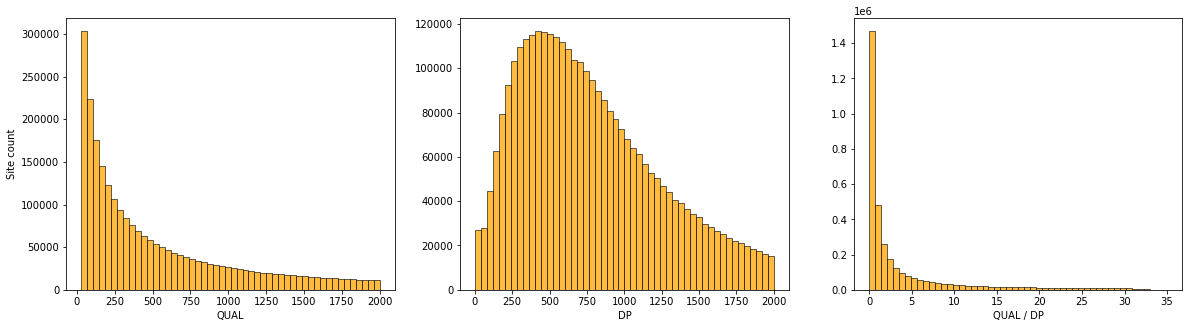

In [43]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(20, 5))

sns.histplot(AB_pass['QUAL'][AB_pass['QUAL'] < 2000], bins = 50, color = "orange", ax = ax[0])
ax[0].set(xlabel='QUAL', ylabel='Site count')
# plt.show()

sns.histplot(AB_pass['DP'][AB_pass['DP'] < 2000], bins = 50, color = "orange", ax = ax[1])
ax[1].set(xlabel='DP', ylabel='')

sns.histplot(AB_pass['QUAL'] / AB_pass['DP'], bins = 50, color = "orange", ax = ax[2])
ax[2].set(xlabel='QUAL / DP', ylabel='')

plt.show()

**Cumulative density plots**

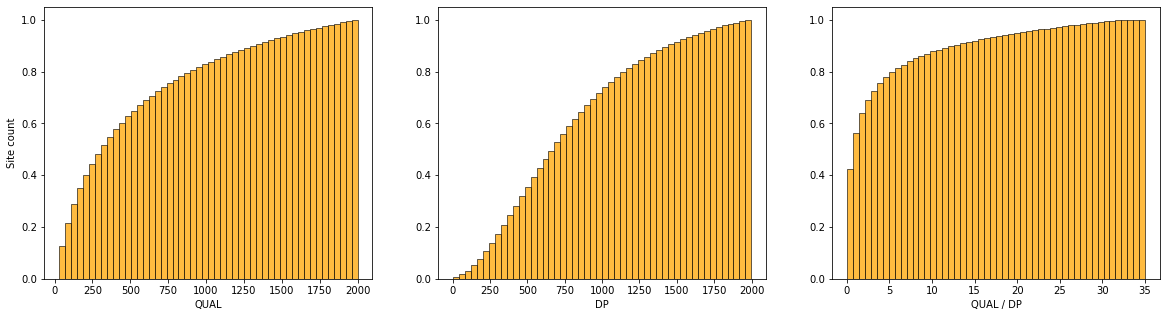

In [44]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(20, 5))

sns.histplot(AB_pass['QUAL'][AB_pass['QUAL'] < 2000], cumulative=True, stat='density', bins = 50, color = "orange", ax = ax[0])
ax[0].set(xlabel='QUAL', ylabel='Site count')
# plt.show()

sns.histplot(AB_pass['DP'][AB_pass['DP'] < 2000], cumulative=True, stat='density', bins = 50, color = "orange", ax = ax[1])
ax[1].set(xlabel='DP', ylabel='')

sns.histplot(AB_pass['QUAL'] / AB_pass['DP'], cumulative=True, stat='density', bins = 50, color = "orange", ax = ax[2])
ax[2].set(xlabel='QUAL / DP', ylabel='')

plt.show()

In [45]:
QD_expr = '(QUAL / DP > 0.25)'
QD_filt = PR_pass.eval(QD_expr)
QD_pass = PR_pass.compress(QD_filt)

In [46]:
num_sites_keptPR = np.count_nonzero(QD_filt)
num_sites_filteredPR = np.count_nonzero(~QD_filt)
print("Removed a total of {0} sites failing Quality by Depth filter. {1} sites remaining".format(num_sites_filteredPR, num_sites_keptPR))

Removed a total of 568946 sites failing Quality by Depth filter. 2297228 sites remaining


#### Criteria 9: Missing genotype calls

Since genotype calls will be used to construct haplotypes for analyses (e.g., tests for positive selection), <br>
we want to make sure most samples have genotype calls. We will remove sites where most samples (e.g., >= 20%) are missing genotype calls.

**Important note: The manual for `selscan`, a program used for performing LD-based tests of selection <br>
based on extended haplotype homozygesity (EHH), specifically states: _Data must be phased and have no missing genotypes_ <br>
I haven't looked at missing data requirements of other programs but I imagine they're similar.**

Setting the filter below to 0% would result in no missing data. The resulting VCF can be phased with BEAGLE or SHAPEIT.

_Filter_: Prop missing genotype calls <= 0% or <= 20%

In [48]:
# Get Indices for positions of SNPs passing all above filters
QD_pass_positions = QD_pass['POS']  # Positions of SNP passing 
chrom1_positions = extract_zarr_annotation(subdir = 'variants', annot = 'POS')[:]  # Array with all positions
position_toKeep = np.in1d(chrom1_positions, QD_pass_positions)  # Boolean array of Positions that passed above filters

In [49]:
# Recode GTs with DP < 3 as missing
GT_vals_lowDP_recode = lowDP_GTrecode(zarr_dp_array = DP_vals, zarr_gt_array = GT_vals, minDP = 3, subset = None)

In [50]:
# Subset GTs at positions that passed above filters
GT_vals_lowDP_recode_filtPass = GT_vals_lowDP_recode[position_toKeep, ]
GT_vals_lowDP_recode_filtPass_lowDPindRem = GT_vals_lowDP_recode_filtPass[:,good_sample_array]

In [51]:
GT_vals_lowDP_recode_filtPass_lowDPindRem.shape

(2297229, 113, 2)

In [52]:
pos_passingGTmissFilter, prop_GTmiss = filter_missGT(GT_vals_lowDP_recode_filtPass_lowDPindRem, missing_gt_prop = 0.2)

52.25% (1200280) of sites have at least 80.0% (90) of samples with genotype calls


**Using our previous cutoff of <= 20% missing genotype data, we retain 1,200,280 SNPs after filtering**

In [53]:
pos_passingGTmissFilter, prop_GTmiss = filter_missGT(GT_vals_lowDP_recode_filtPass_lowDPindRem, missing_gt_prop = 0)

6.16% (141557) of sites have at least 100% (113) of samples with genotype calls


**Keeping only sites with no missing data, we retain 141,557 SNPs**

**RAW data plot**

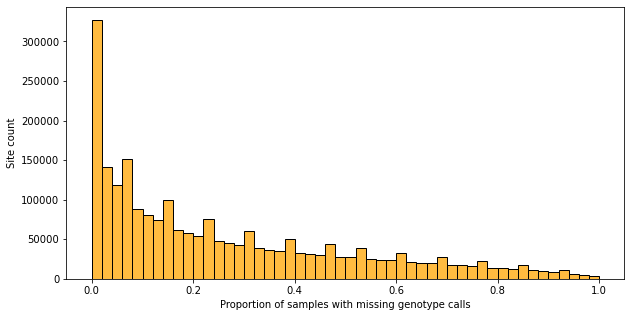

In [54]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 5))
sns.histplot(prop_GTmiss, color = "orange", bins = 50, axes = ax)
ax.set(xlabel='Proportion of samples with missing genotype calls', ylabel='Site count')
plt.show()

**Cumulative density plot**

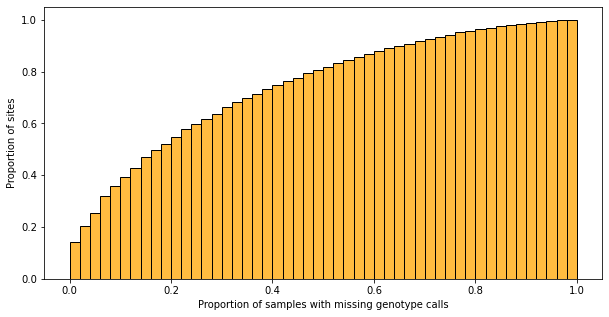

In [55]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 5))
sns.histplot(prop_GTmiss, color = "orange", cumulative=True, stat='density', bins = 50, axes = ax)
ax.set(xlabel='Proportion of samples with missing genotype calls', ylabel='Proportion of sites')
plt.show()

## Invariant sites

Will minimally filter the invariant site VCF to estimate denominator in calculating diversity.

In [64]:
invar_table = allel.VariantChunkedTable(invar_callset['variants'], 
                                     names=['POS', 'REF', 'ALT', 'QUAL', 'DP', 'MQMR'],
                                     index='POS')[:]

In [65]:
MQinvar_expr = 'MQMR >= 30'
MQinvar_filt = invar_table.eval(MQinvar_expr)
MQinvar_pass = invar_table.compress(MQinvar_filt)

In [66]:
num_sites_keptMQinvar = np.count_nonzero(MQinvar_filt)
num_sites_filteredMQinvar = np.count_nonzero(~MQinvar_filt)
print("Removed a total of {0} invariant sites failing Mapping Quality filter. {1} sites remaining".format(num_sites_filteredMQinvar, num_sites_keptMQinvar))

Removed a total of 5914692 invariant sites failing Mapping Quality filter. 49805956 sites remaining


In [67]:
MQinvar_pass_positions = MQinvar_pass['POS']
chrom1_invar_positions = extract_zarr_annotation(subdir = 'variants', annot = 'POS', zarr_db = invar_callset)
position_toKeep = np.in1d(chrom1_invar_positions, MQinvar_pass_positions)  # Boolean array of Positions that passed above filters

In [68]:
GT_vals_invar = extract_zarr_annotation(subdir = 'calldata', annot = 'GT', zarr_db = invar_callset)[:]

In [69]:
# Subset GTs at positions that passed above filters
GT_vals_invar_MQpass = GT_vals_invar[position_toKeep, ]
GT_vals_invar_MQpass_lowDPindRem = GT_vals_invar_MQpass[:,good_sample_array]

In [70]:
posInvar_passingGTmissFilter, prop_GTmiss_invar = filter_missGT(GT_vals_invar_MQpass_lowDPindRem, missing_gt_prop = 0.2)

68.42% (34078224) of sites have at least 80.0% (90) of samples with genotype calls


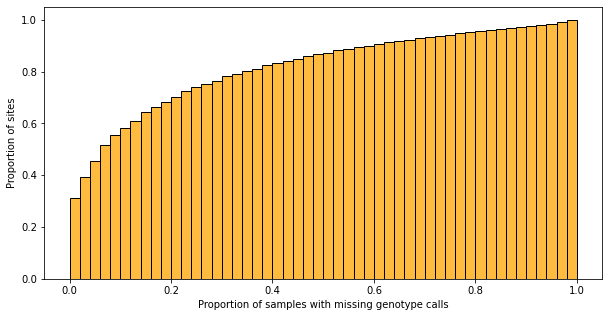

In [71]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 5))
sns.histplot(prop_GTmiss_invar, color = "orange", cumulative=True, stat='density', bins = 50, axes = ax)
ax.set(xlabel='Proportion of samples with missing genotype calls', ylabel='Proportion of sites')
plt.show()

## Some concluding notes

1. Changes to the filtering criteria since our last meeting has increased the number of SNPs retained post-filtering.
    - In total, we retain 1,200,280 SNPs if we allow up to 20% missing genotype data, or 141,557 SNPs if we allow no missing genotypes
2. By minimally filtering the invariant sites on mapping quality and missing genotype data, we retain 34,078,224 invariant sites
    - Together with the SNPs, this results in a mean estimated **SNP density along chromosome 1 of 0.034**, which is in the ballpark
    of that reported in the genome paper. 
    
**Recommendations going forward:**

1. Haplotype phasing programs and tests of selection based on haplotype homozygosity (e.g., XP-EHH) don't allow missing data.
    - We'll have to use the VCF with no missing data, containing 141,557 SNPs; this should be fine for these analyses.
    - Some of these tests (e.g., integrated haplotype score, iHs) require knowledge of the ancestral/derived allele state. We could infer this by leveraging the genomes of closely-related clover species (e.g., red clover, subterranean clover) but I'm still thinking about whether it's worth it. It opens up some additional analyses, but isn't essential. 
2. For other analyses that require a VCF (e.g., demographic modeling), use the VCF that allows for up to 20% missing genotype data. 
    - For example, we can identify all of the 4-fold degenerate sites in this VCF and use those for demographic modeling. That would be more than enough SNPs. 
3. All other analyses -- Fst outlier, pairwise population differentiation, pi, Tajima's D, SFS skew (e.g., `SweepFinder2`) -- can be performed using the SFS, which I'll estimate directly from the raw reads using `ANGSD`. 